In [12]:
import os
import matplotlib.pyplot as plt
from natsort import natsorted, ns
from tqdm import tqdm

xlim = (0, 15)
ylim = (-1.5, 1.5)
zero_start = True
base_path = "/home/kwakrhkr59/XAI_WF/data/firefox_fiber"

nodef_dir = f"/scratch4/starlink/WFdata75x80/firefox_fiber"
wtf_dir = f"/home/kwakrhkr59/XAI_WF/defense/wtfpad/results/default_250626_163519"
if zero_start:
    output_dir = f"{base_path}/data/combined_firefox_fiber_{ylim[0]}_{ylim[1]}_{xlim[1]}_zero_bar_subplots/"
else:
    output_dir = f"{base_path}/data/combined_firefox_fiber_{ylim[0]}_{ylim[1]}_{xlim[1]}_bar_subplots/"

In [13]:
def sign(value):
    """값이 0보다 크면 1, 0보다 작으면 -1, 0이면 0을 반환합니다."""
    return (value > 0) - (value < 0)

def read_file_data(file_path):
    """주어진 파일에서 타임스탬프와 값을 읽어옵니다."""
    all_timestamps = []
    all_values = []
    with open(file_path, 'r', encoding='utf-8') as f:
        first_line = f.readline().strip()
        if first_line:
            start_time = float(first_line[0]) if zero_start else 0.0
        else:
            start_time = 0.0

        for line in f:
            parts = list(map(float, line.split()))
            all_timestamps.append(parts[0] - start_time)
            all_values.append(parts[1])
            if parts[0] - start_time > xlim[1]:
                break
    return all_timestamps, all_values

In [ ]:
import os
import matplotlib.pyplot as plt
from natsort import natsorted, ns
from tqdm import tqdm

# xlim과 ylim은 이제 함수 내에서 동적으로 설정됩니다.
ylim = (-3000, 300)
zero_start = True # 이 값은 첫 번째 타임스탬프를 0으로 맞출지 여부를 결정합니다.
base_path = "/home/kwakrhkr59/XAI_WF/data/firefox_fiber"

def read_file_data(file_path):
    """주어진 파일에서 타임스탬프와 값을 읽어옵니다. 첫 번째 타임스탬프를 0으로 정규화합니다."""
    all_timestamps = []
    all_values = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines() # 모든 줄을 한 번에 읽기
        
        if not lines: # 파일이 비어있는 경우 처리
            print(f"경고: {file_path} 파일이 비어있습니다. 건너뜝니다.")
            return [], [], None, None # 빈 리스트와 None 반환

        # 첫 번째 실제 데이터 라인을 찾습니다.
        # 첫 번째 라인은 start_time을 결정하는 데 사용될 수 있습니다.
        first_data_point_time = None
        
        # start_time을 파일의 첫 번째 데이터 포인트로 설정 (zero_start가 True인 경우)
        # 파일의 첫 번째 줄(meta-info)이 아닌, 실제 데이터의 첫 번째 타임스탬프를 기준으로 합니다.
        if zero_start:
            # 첫 번째 실제 데이터 라인을 찾아서 첫 번째 타임스탬프를 가져옵니다.
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2: # 최소한 타임스탬프와 값이 있어야 함
                    try:
                        first_data_point_time = float(parts[0])
                        break # 첫 번째 유효한 데이터 포인트를 찾으면 반복 중단
                    except ValueError:
                        continue # 숫자가 아니면 다음 줄로
            
            if first_data_point_time is None:
                print(f"경고: {file_path}에서 유효한 첫 번째 타임스탬프를 찾을 수 없습니다. 0.0으로 기본 설정합니다.")
                start_time_offset = 0.0
            else:
                start_time_offset = first_data_point_time
        else:
            start_time_offset = 0.0 # zero_start가 False면 오프셋 없음

        # 데이터 파싱
        # 첫 번째 줄은 메타데이터이거나 유효한 데이터가 아닐 수 있으므로 다시 읽습니다.
        # 또는 위에서 `lines`로 모두 읽었으므로 `lines` 리스트를 사용합니다.
        
        # lines 리스트의 각 줄을 처리
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 2: # 타임스탬프와 값이 모두 존재하는지 확인
                try:
                    timestamp = float(parts[0])
                    value = float(parts[1])
                    all_timestamps.append(timestamp - start_time_offset)
                    all_values.append(value)
                except ValueError:
                    continue # 숫자로 변환할 수 없으면 건너뛰기
    
    # xlim에 사용될 min/max 타임스탬프 계산 (정규화된 값)
    min_timestamp = min(all_timestamps) if all_timestamps else 0
    max_timestamp = max(all_timestamps) if all_timestamps else 0

    return all_timestamps, all_values, min_timestamp, max_timestamp

def plot_combined_waves_as_bars(nodef_dir, wtf_dir, output_base_path):
    nodef_files = set(os.listdir(nodef_dir))
    wtf_files = set(os.listdir(wtf_dir))

    common_files = natsorted(list(nodef_files.intersection(wtf_files)), alg=ns.IGNORECASE)

    bar_width = 0.05 

    for file_name in tqdm(common_files, desc="Processing Combined Files", unit="file"):
        nodef_file_path = os.path.join(nodef_dir, file_name)
        wtf_file_path = os.path.join(wtf_dir, file_name)

        # 두 파일의 데이터 읽기 및 xlim을 위한 타임스탬프 범위 가져오기
        nodef_timestamps, nodef_values, nodef_min_t, nodef_max_t = read_file_data(nodef_file_path)
        wtf_timestamps, wtf_values, wtf_min_t, wtf_max_t = read_file_data(wtf_file_path)

        # 데이터가 없는 경우 건너뛰기
        if not nodef_timestamps and not wtf_timestamps:
            print(f"경고: {file_name} (nodef 및 wtf) 파일에 유효한 데이터가 없습니다. 건너뜝니다.")
            continue

        # 두 데이터셋의 전체 타임스탬프 범위 통합
        # 한쪽만 데이터가 있을 경우를 대비해 None 체크
        combined_min_t = min(t for t in [nodef_min_t, wtf_min_t] if t is not None) if (nodef_min_t is not None or wtf_min_t is not None) else 0
        combined_max_t = max(t for t in [nodef_max_t, wtf_max_t] if t is not None) if (nodef_max_t is not None or wtf_max_t is not None) else 0
        
        # xlim을 첫 번째 값과 마지막 값으로 설정 (정규화된 값)
        current_xlim = (combined_min_t, combined_max_t)
        
        # X축 범위에 여유를 주려면 다음과 같이 조정할 수 있습니다:
        # padding = (current_xlim[1] - current_xlim[0]) * 0.05 # 5% 패딩
        # current_xlim = (current_xlim[0] - padding, current_xlim[1] + padding)


        fig, axes = plt.subplots(1, 2, figsize=(12, 4), facecolor='white')

        # nodef_path 데이터 그리기
        if nodef_timestamps: # 데이터가 있는 경우에만 그리기
            axes[0].bar(nodef_timestamps, nodef_values, width=bar_width, label=f"nodef: {file_name}", color='red')
        axes[0].set_title(f"nodef: {file_name}")
        axes[0].set_xlim(current_xlim) # 동적으로 설정된 xlim 적용
        axes[0].set_ylim(ylim)
        axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

        # wtf_path 데이터 그리기
        if wtf_timestamps: # 데이터가 있는 경우에만 그리기
            axes[1].bar(wtf_timestamps, wtf_values, width=bar_width, label=f"wtf: {file_name}", color='blue')
        axes[1].set_title(f"wtf: {file_name}")
        axes[1].set_xlim(current_xlim) # 동적으로 설정된 xlim 적용
        axes[1].set_ylim(ylim)
        axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

        plt.tight_layout()

        save_folder = os.path.join(output_base_path, file_name.split('-')[0])
        os.makedirs(save_folder, exist_ok=True)

        save_path = os.path.join(save_folder, f"combined_bar_dynamic_xlim_{file_name.split('-')[1]}.png")
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, facecolor='white', transparent=False)
        plt.show()

        if input("Press Enter to continue or type 'exit' to quit: ").strip().lower() == 'exit':
            break

        plt.close(fig)


plot_combined_waves_as_bars(nodef_dir, wtf_dir, output_dir)

Processing Combined Files:   0%|          | 0/6000 [00:00<?, ?file/s]

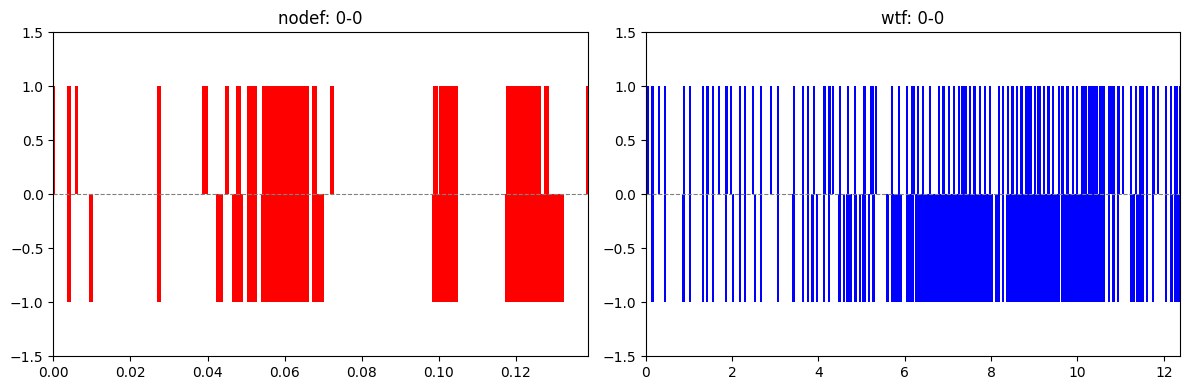

Processing Combined Files:   0%|          | 1/6000 [00:08<14:38:41,  8.79s/file]

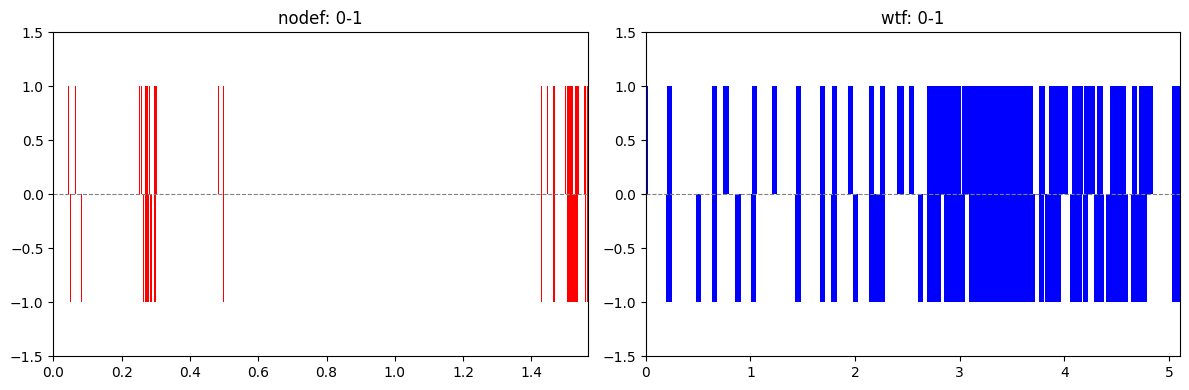

Processing Combined Files:   0%|          | 2/6000 [00:17<14:42:04,  8.82s/file]

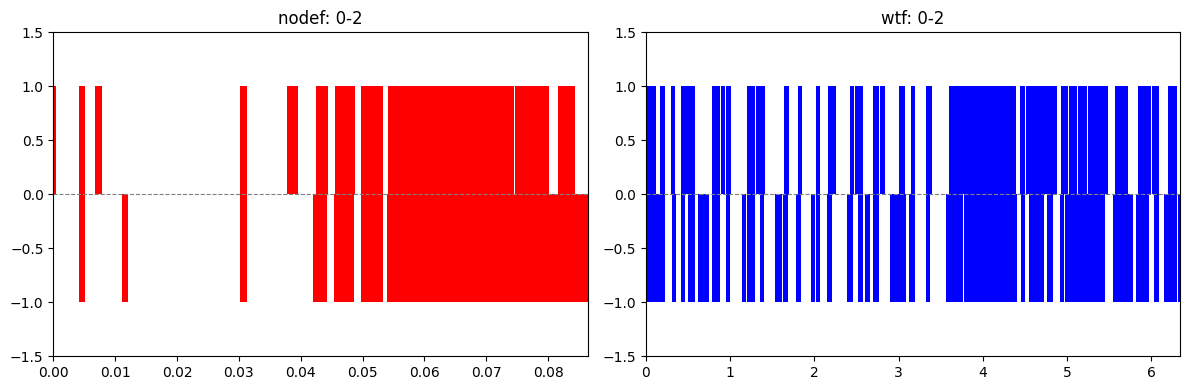

Processing Combined Files:   0%|          | 3/6000 [00:26<14:21:37,  8.62s/file]

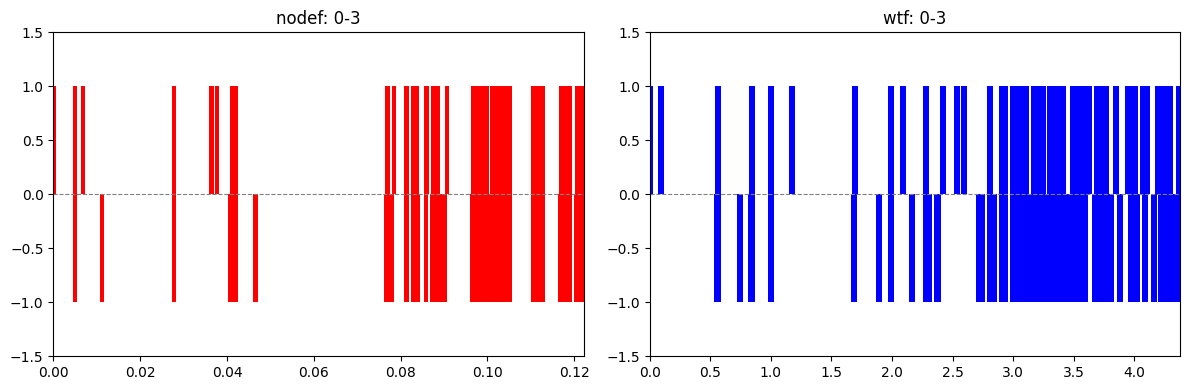

Processing Combined Files:   0%|          | 4/6000 [00:31<12:31:21,  7.52s/file]

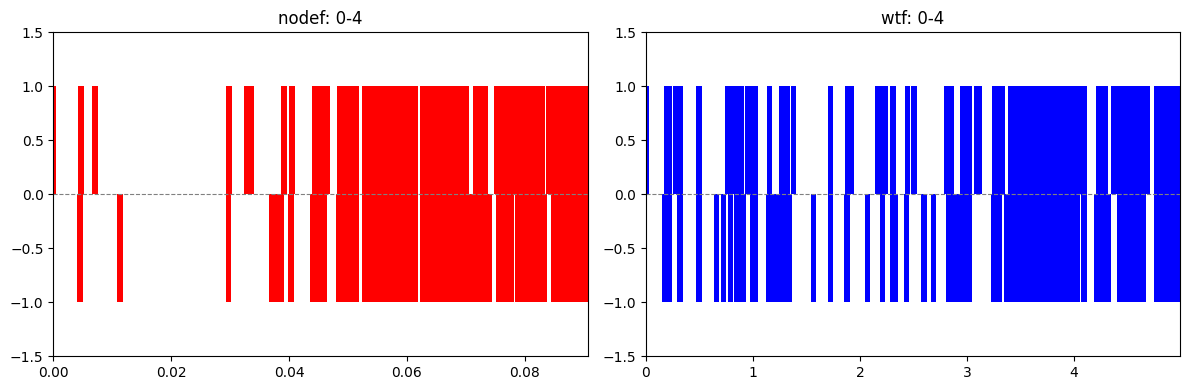

Processing Combined Files:   0%|          | 5/6000 [00:38<12:13:10,  7.34s/file]

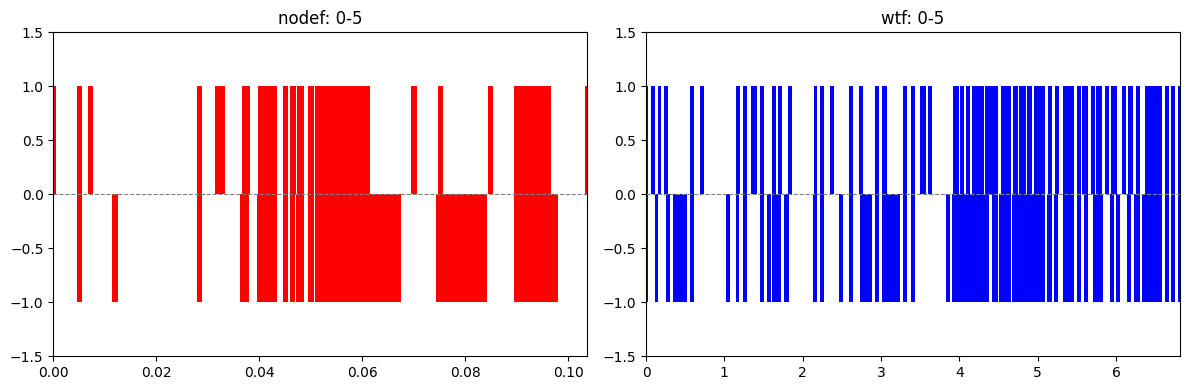

Processing Combined Files:   0%|          | 6/6000 [00:48<13:45:43,  8.27s/file]

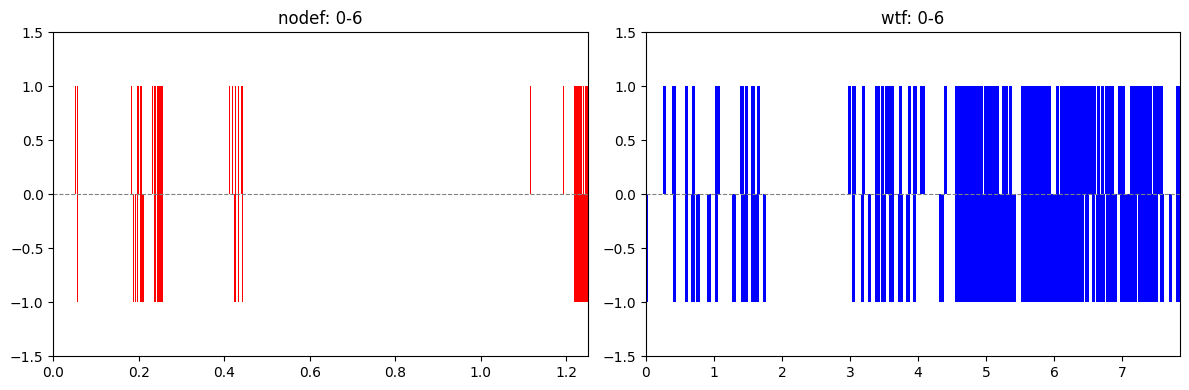

Processing Combined Files:   0%|          | 7/6000 [00:55<12:36:12,  7.57s/file]

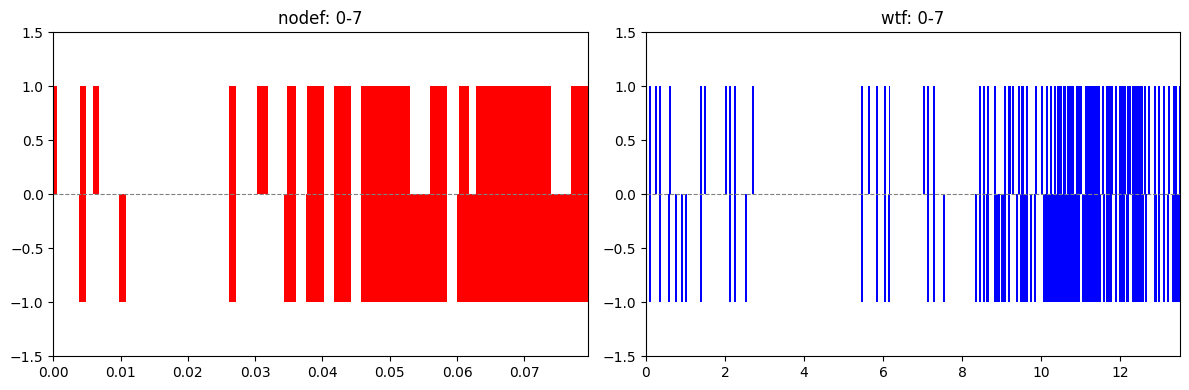

Processing Combined Files:   0%|          | 7/6000 [01:03<15:09:38,  9.11s/file]


In [ ]:
def read_file_data(file_path):
    """주어진 파일에서 타임스탬프와 값을 읽어옵니다. 첫 번째 타임스탬프를 0으로 정규화할 수 있습니다."""
    all_timestamps = []
    all_values = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
        if not lines: # 파일이 비어있는 경우 처리
            print(f"경고: {file_path} 파일이 비어있습니다. 건너뜝니다.")
            return [], [], None, None # 빈 리스트와 None 반환

        # 파일 내의 첫 번째 실제 데이터 포인트를 찾아 start_time_offset을 결정합니다.
        first_data_point_time = None
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 2: # 최소한 타임스탬프와 값이 있어야 함
                try:
                    first_data_point_time = float(parts[0])
                    break # 첫 번째 유효한 데이터 포인트를 찾으면 반복 중단
                except ValueError:
                    continue # 숫자가 아니면 다음 줄로
        
        if first_data_point_time is None:
            print(f"경고: {file_path}에서 유효한 첫 번째 타임스탬프를 찾을 수 없습니다. 0.0으로 기본 설정합니다.")
            start_time_offset = 0.0
        else:
            # zero_start가 True면 첫 번째 데이터 포인트를 0으로 맞추고, 아니면 0 오프셋
            start_time_offset = first_data_point_time if zero_start else 0.0

        # 데이터 파싱 및 정규화된 타임스탬프 저장
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 2: # 타임스탬프와 값이 모두 존재하는지 확인
                try:
                    timestamp = float(parts[0])
                    value = float(parts[1])
                    all_timestamps.append(timestamp - start_time_offset)
                    all_values.append(sign(value))
                except ValueError:
                    continue # 숫자로 변환할 수 없으면 건너뛰기
    
    # xlim에 사용될 min/max 타임스탬프 계산 (정규화된 값)
    min_timestamp = min(all_timestamps) if all_timestamps else 0
    max_timestamp = max(all_timestamps) if all_timestamps else 0

    return all_timestamps, all_values, min_timestamp, max_timestamp

nodef_files = set(os.listdir(nodef_dir))
wtf_files = set(os.listdir(wtf_dir))

common_files = natsorted(list(nodef_files.intersection(wtf_files)), alg=ns.IGNORECASE)

nodef_bar_width = 0.0005
wtf_bar_width = 0.05

for file_name in tqdm(common_files, desc="Processing Combined Files", unit="file"):
    nodef_file_path = os.path.join(nodef_dir, file_name)
    wtf_file_path = os.path.join(wtf_dir, file_name)

    # 두 파일의 데이터 및 각자의 타임스탬프 범위 가져오기
    nodef_timestamps, nodef_values, nodef_min_t, nodef_max_t = read_file_data(nodef_file_path)
    wtf_timestamps, wtf_values, wtf_min_t, wtf_max_t = read_file_data(wtf_file_path)

    # 두 파일 모두 유효한 데이터가 없으면 건너뛰기
    if not nodef_timestamps and not wtf_timestamps:
        print(f"경고: {file_name} (nodef 및 wtf) 파일에 유효한 데이터가 없습니다. 건너뜝니다.")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), facecolor='white')

    # nodef_path 데이터 그리기
    if nodef_timestamps: # 데이터가 있는 경우에만 그리기
        axes[0].bar(nodef_timestamps, nodef_values, width=nodef_bar_width, label=f"nodef: {file_name}", color='red')
        # nodef 데이터의 실제 범위로 xlim 설정
        axes[0].set_xlim((nodef_min_t, nodef_max_t))
    else:
        # 데이터가 없는 경우 기본 xlim 설정 (예: 0부터 1까지)
        axes[0].set_xlim((0, 1)) 
    axes[0].set_title(f"nodef: {file_name}")
    axes[0].set_ylim(ylim)
    axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

    # wtf_path 데이터 그리기
    if wtf_timestamps: # 데이터가 있는 경우에만 그리기
        axes[1].bar(wtf_timestamps, wtf_values, width=wtf_bar_width, label=f"wtf: {file_name}", color='blue')
        # wtf 데이터의 실제 범위로 xlim 설정
        axes[1].set_xlim((wtf_min_t, wtf_max_t))
    else:
        # 데이터가 없는 경우 기본 xlim 설정
        axes[1].set_xlim((0, 1))
    axes[1].set_title(f"wtf: {file_name}")
    axes[1].set_ylim(ylim)
    axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

    plt.tight_layout()

    save_folder = os.path.join(output_dir, file_name.split('-')[0])
    os.makedirs(save_folder, exist_ok=True)

    # 파일 이름에 'individual_xlim'을 추가하여 구분
    save_path = os.path.join(save_folder, f"combined_bar_individual_xlim_{file_name.split('-')[1]}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, facecolor='white', transparent=False)
    plt.show()

    if input("Press Enter to continue or type 'exit' to quit: ").strip().lower() == 'exit':
        break
    plt.close(fig)

In [ ]:
plot_combined_waves_as_bars(nodef_dir, wtf_dir, output_dir)